In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt

<Axes: >

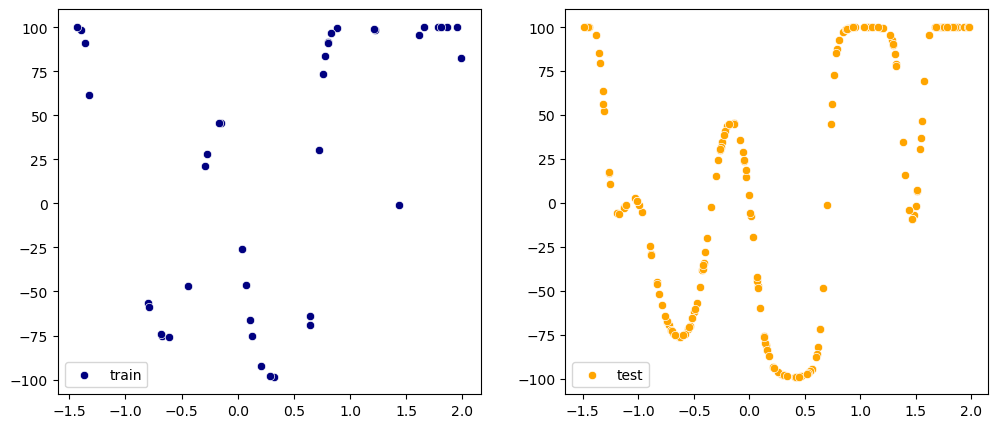

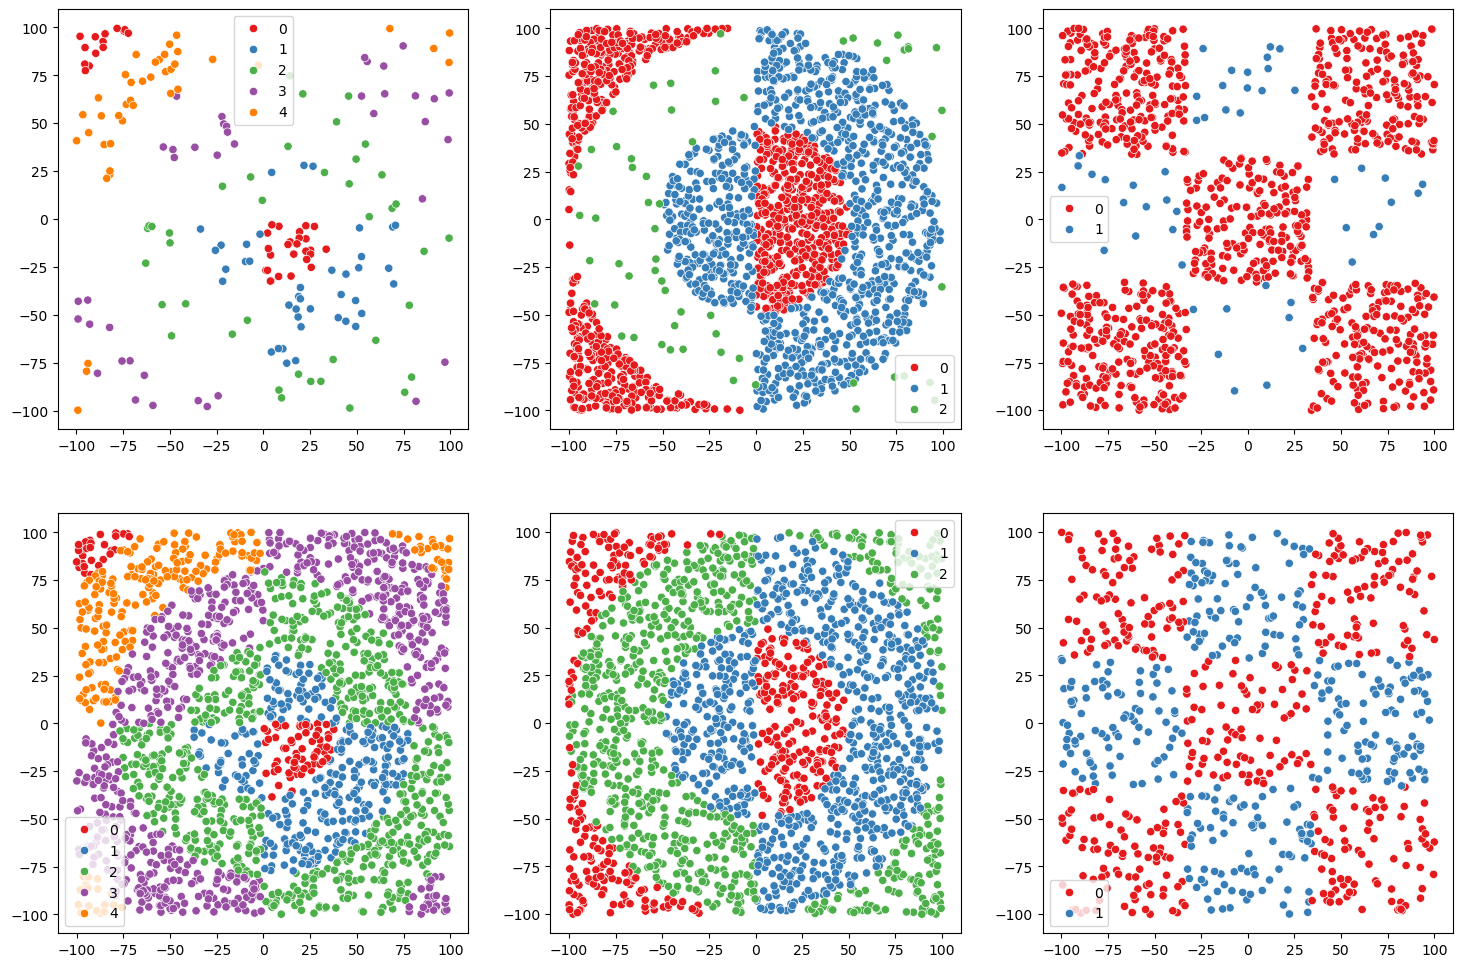

In [2]:
multimodal_sparse_train = pd.read_csv('../data/regression/multimodal-sparse-training.csv')[['x', 'y']]
multimodal_sparse_test = pd.read_csv('../data/regression/multimodal-sparse-test.csv')[['x', 'y']]

rings5_sparse_train = pd.read_csv('../data/classification/rings5-sparse-training.csv')[['x', 'y', 'c']]
rings5_sparse_test = pd.read_csv('../data/classification/rings5-sparse-test.csv')[['x', 'y', 'c']]

rings3_balance_train = pd.read_csv('../data/classification/rings3-balance-training.csv')[['x', 'y', 'c']]
rings3_balance_test = pd.read_csv('../data/classification/rings3-balance-test.csv')[['x', 'y', 'c']]

xor3_balance_train = pd.read_csv('../data/classification/xor3-balance-training.csv')[['x', 'y', 'c']]
xor3_balance_test = pd.read_csv('../data/classification/xor3-balance-test.csv')[['x', 'y', 'c']]


multimodal_sparse_train_X = np.array(multimodal_sparse_train['x'])
multimodal_sparse_train_Y = np.array(multimodal_sparse_train['y'])

multimodal_sparse_test_X = np.array(multimodal_sparse_test['x'])
multimodal_sparse_test_Y = np.array(multimodal_sparse_test['y'])

rings5_sparse_train_X = np.array(rings5_sparse_train['x'])
rings5_sparse_train_Y = np.array(rings5_sparse_train['y'])
rings5_sparse_train_C = np.array(rings5_sparse_train['c'])

rings5_sparse_test_X = np.array(rings5_sparse_test['x'])
rings5_sparse_test_Y = np.array(rings5_sparse_test['y'])
rings5_sparse_test_C = np.array(rings5_sparse_test['c'])

rings3_balance_train_X = np.array(rings3_balance_train['x'])
rings3_balance_train_Y = np.array(rings3_balance_train['y'])
rings3_balance_train_C = np.array(rings3_balance_train['c'])

rings3_balance_test_X = np.array(rings3_balance_test['x'])
rings3_balance_test_Y = np.array(rings3_balance_test['y'])
rings3_balance_test_C = np.array(rings3_balance_test['c'])

xor3_balance_train_X = np.array(xor3_balance_train['x'])
xor3_balance_train_Y = np.array(xor3_balance_train['y'])
xor3_balance_train_C = np.array(xor3_balance_train['c'])

xor3_balance_test_X = np.array(xor3_balance_test['x'])
xor3_balance_test_Y = np.array(xor3_balance_test['y'])
xor3_balance_test_C = np.array(xor3_balance_test['c'])


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=multimodal_sparse_train_X, y=multimodal_sparse_train_Y, label = 'train', ax=axes[0], color='navy')
sns.scatterplot(x=multimodal_sparse_test_X, y=multimodal_sparse_test_Y, label = 'test', ax=axes[1], color='orange')

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sns.scatterplot(x=rings5_sparse_train_X, y=rings5_sparse_train_Y, hue=rings5_sparse_train_C, ax=axes[0, 0], palette='Set1')
sns.scatterplot(x=rings3_balance_train_X, y=rings3_balance_train_Y, hue=rings3_balance_train_C, ax=axes[0, 1], palette='Set1')
sns.scatterplot(x=xor3_balance_train_X, y=xor3_balance_train_Y, hue=xor3_balance_train_C, ax=axes[0, 2], palette='Set1')
sns.scatterplot(x=rings5_sparse_test_X, y=rings5_sparse_test_Y, hue=rings5_sparse_test_C, ax=axes[1, 0], palette='Set1')
sns.scatterplot(x=rings3_balance_test_X, y=rings3_balance_test_Y, hue=rings3_balance_test_C, ax=axes[1, 1], palette='Set1')
sns.scatterplot(x=xor3_balance_test_X, y=xor3_balance_test_Y, hue=xor3_balance_test_C, ax=axes[1, 2], palette='Set1')

In [3]:
def sigmoid(x):
	return 1/(1+np.e**(-x))

def sigmoid_derivative(x):
	return sigmoid(x) * (1 - sigmoid(x))

def linear(x):
	return x

def linear_derivative(x):
	return 1

def softmax(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)  
    
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def tanh(x):
	return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def tanh_derivative(x):
	return 1 - tanh(x)**2

def ReLU(x):
	return np.maximum(0, x)

def ReLU_derivative(x):
	return np.where(x > 0, 1, 0)

class network:
	def __init__(self, architecture, activation_functions, activation_derivatives, initiation_method):
		self.architecture = architecture
		self.activation_functions = activation_functions
		self.activation_derivatives = activation_derivatives
		self.weights_biases_initiation(initiation_method)
		self.loss_record = []
		self.f1_score = []
		self.mask = None

	def set_state(self, architecture, biases, weights, activation_functions):
		self.architecture = architecture
		self.biases = biases
		self.weights = weights
		self.activation_functions = activation_functions

	def weights_biases_initiation(self, initiation_method):
		self.weights = [None]
		self.biases = [None]
		self.weights_momentum = [None]
		self.biases_momentum = [None]
		self.weigths_rmsProp = [None]
		self.biases_rmsProp = [None]

		if initiation_method not in ['he', 'xavier', 'uniform']:
			print('Initiation method incorrect!')
			return 

		for i in range(len(self.architecture) - 1):
			input_dim = self.architecture[i]
			output_dim = self.architecture[i + 1]
			
			if initiation_method == 'he':
				weight_matrix = np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim)
			elif initiation_method == 'xavier':
				weight_matrix = np.random.randn(input_dim, output_dim) * np.sqrt(1 / input_dim)
			elif initiation_method == 'uniform':
				weight_matrix = np.random.uniform(0, 1, (input_dim, output_dim))

			bias_vector = np.zeros((1, output_dim))
			
			self.weights_momentum.append(np.zeros(weight_matrix.shape))
			self.biases_momentum.append(np.zeros(bias_vector.shape))
			self.weigths_rmsProp.append(np.zeros(weight_matrix.shape))
			self.biases_rmsProp.append(np.zeros(bias_vector.shape))
			self.weights.append(weight_matrix)
			self.biases.append(bias_vector)

	def forward(self, X, dropout_p=None):
		# as a convention, for convinience, zeroth index of activations is raw input, i add None to preactivations for uniform indexing
		self.activations = [X]
		self.preactivations = [None]

		for i in range(0, len(self.architecture)-1):
			z = np.dot(self.activations[i], self.weights[i+1]) + self.biases[i+1]
			self.preactivations.append(z)
			
			a = self.activation_functions[i+1](z)
			if dropout_p != None:
				a = a * self.mask[i+1]

			self.activations.append(a)
	
	def check_MSE(self, x, y):
		self.forward(x)
		prediction = self.destandardize_data(self.activations[-1], 'y')
		correct = self.destandardize_data(y, 'y')
		return np.mean((correct - prediction) ** 2)
	
	def check_categorical_crossentropy_loss(self, x, y, epsilon=1e-12):
		self.forward(x)
		prediction = self.activations[-1]
		prediction = np.clip(prediction, epsilon, 1.0 - epsilon)
		loss = -np.sum(y * np.log(prediction), axis=1)
		return np.mean(loss)

	def check_fmeasure(self, x, y):
		self.forward(x)
		prediction = np.argmax(self.activations[-1], axis=1)
		correct = np.argmax(y, axis=1)

		labels = np.unique(y)

		true_positives = np.zeros(len(labels))
		false_positives = np.zeros(len(labels))
		false_negatives = np.zeros(len(labels))

		for i, label in enumerate(labels):
			true_positives[i] = np.sum((prediction == label) & (correct == label))
			false_positives[i] = np.sum((prediction == label) & (correct != label))
			false_negatives[i] = np.sum((prediction != label) & (correct == label))

		precision = true_positives / (true_positives+false_positives + 1e-10)
		recall = true_positives / (true_positives+false_negatives + 1e-10)

		f1_per_class = 2 * (precision * recall) / (precision + recall + 1e-10)
		return np.mean(f1_per_class)
	
	def visualize_network(self):
		G = nx.DiGraph()
		pos = {}
		edge_colors = []
		edge_widths = []
		
		for layer_idx, num_nodes in enumerate(self.architecture):
			for node_idx in range(num_nodes):
				node_name = f"L{layer_idx}_N{node_idx}"
				pos[node_name] = (layer_idx, -node_idx)  
				G.add_node(node_name)
				
				if layer_idx > 0: 
					for prev_idx in range(self.architecture[layer_idx - 1]):
						prev_name = f"L{layer_idx-1}_N{prev_idx}"
						weight = self.weights[layer_idx][prev_idx][node_idx]

						if weight != 0:
							G.add_edge(prev_name, node_name)
							edge_colors.append('red' if weight < 0 else 'green')
							edge_widths.append(np.log(abs(weight)))
		
		plt.figure(figsize=(10, 5))
		nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", edge_color=edge_colors, width=edge_widths)
		plt.show()

	def backward(self, Y, dropout_p=None, reg_type=None, lambda_=None):
		self.error = [None] * (len(self.weights))
		self.weights_gradient = [None] * (len(self.weights))
		self.biases_gradient = [None] * (len(self.weights))

		# if task == 'regression':
		# 	self.error[-1] = (self.activations[-1] - Y) * self.activation_derivatives[-1](self.preactivations[-1])
		# if task == 'classification':
		# 	self.error[-1] = (self.activations[-1] - Y)
		
		# normalnie to to kwestia czy regresja czy klasyfikacja ale żeby spróbować klasyfikacji dla liniowej ostatniej warstywy robie tak 
		if self.activation_functions[-1] != softmax: 
			self.error[-1] = (self.activations[-1] - Y) * self.activation_derivatives[-1](self.preactivations[-1])
		else:
			self.error[-1] = (self.activations[-1] - Y)

		for i in reversed(range(1, len(self.error) - 1)):
			self.error[i] = np.dot(self.error[i+1], self.weights[i+1].T) * self.activation_derivatives[i](self.preactivations[i])
			if dropout_p != None:
				self.error[i] = self.error[i] * self.mask[i]
		
		for i in range(1, len(self.error)):
			# self.weights_gradient[i] = -step * np.dot(self.activations[i-1].T, self.error[i]) / self.error[i].shape[0]
			# self.biases_gradient[i] = (-step * np.mean(self.error[i], axis=0)).reshape(1, -1)
			self.weights_gradient[i] = np.dot(self.activations[i-1].T, self.error[i]) / self.error[i].shape[0]
			self.biases_gradient[i] = (np.mean(self.error[i], axis=0)).reshape(1, -1)

			if reg_type == 'L1':
				self.weights_gradient[i] += lambda_ * np.sign(self.weights[i])
			elif reg_type == 'L2':
				self.weights_gradient[i] += lambda_ * self.weights[i]

	def prepeare_batches(self, x, y, task, batch_size=None):
			n = len(x)
			if batch_size == None:
				batch_number = 1
			else:
				batch_number = int(np.ceil(n / batch_size))

			indices = np.random.permutation(n)
			x_shuffled = x[indices]
			y_shuffled = y[indices]

			x_batched = np.array_split(x_shuffled, batch_number)
			y_batched = np.array_split(y_shuffled, batch_number)

			return x_batched, y_batched, batch_number
		
	def prepare_data(self, x, y, task):
		if type(x) == list:
			input_size = len(x)
			for i in range(input_size):
				size = len(x[i])
				x[i] = np.reshape(x[i], (size, 1))
			x = np.hstack(x)
		else:
			x = np.reshape(x, (len(x), 1))
		
		y = np.reshape(y, (len(y), 1))

		x_standardized = self.standardize_data(x, 'x')

		if task == 'classification':
			labels = np.unique(y)
			label_to_index = {label: index for index, label in enumerate(labels)}
			indexes = np.array([label_to_index[label] for label in y.flatten()])

			labels_num = len(labels)
			y = np.eye(labels_num)[indexes]

			return x_standardized, y
		else:
			y_standardized = self.standardize_data(y, 'y')

			return x_standardized, y_standardized
	
	def learn_old(self, x, y, step, iterations):
		x = self.standardize_data(x, 'x')
		y = self.standardize_data(y, 'y')

		for e in range(iterations):
			self.forward(x)
			self.backward(y, step)
			
			for i in range(1, len(self.architecture)):
					self.weights[i] += self.weights_gradient[i]
					self.biases[i] += self.biases_gradient[i]

			self.mse_record.append(self.check_MSE(x, y))

	def learn(self, task, x, y, epochs_number, step, momentum_dumping=None, rmsprop_dumping=None, batch_size=None, dropout_p=None, reg_type=None, lambda_=None):
		if momentum_dumping != None and rmsprop_dumping != None:
			print('Both momentum and rmsProp parameters were passed! Choose one.')
			return 
		
		if task not in ['classification', 'regression']:
			print('Incorrect network task! Choose classification or regression.')
			return
		
		x, y = self.prepare_data(x, y, task)
		
		for e in range(epochs_number):
			x_batches, y_batches, batch_number = self.prepeare_batches(x, y, task, batch_size)

			for b in range(batch_number):
				if dropout_p != None:
					inner_layers = self.architecture[1:-1]
					neurons_count = np.sum(inner_layers)

					self.mask = (np.random.rand(neurons_count) > dropout_p).astype(int)
					splits = np.cumsum(inner_layers[:-1])
					self.mask = np.split(self.mask, splits)
					mask_first = np.array([1] * self.architecture[0])
					mask_last = np.array([1] * self.architecture[-1])
					self.mask = [mask_first] + self.mask + [mask_last]

					input_size = x_batches[b].shape[0]
					self.mask = [np.tile(array, (input_size, 1)) for array in self.mask]
					
				self.forward(x_batches[b], dropout_p)
				self.backward(y_batches[b], dropout_p, reg_type, lambda_)

				for i in range(1, len(self.architecture)):
					if momentum_dumping == None and rmsprop_dumping == None:
						# simple learning
						self.weights[i] -= self.weights_gradient[i] * step
						self.biases[i] -= self.biases_gradient[i] * step

					elif momentum_dumping != None and rmsprop_dumping == None:
						# learning with momentum
						self.weights_momentum[i] = self.weights_momentum[i] * momentum_dumping - self.weights_gradient[i]
						self.biases_momentum[i] = self.biases_momentum[i] * momentum_dumping - self.biases_gradient[i]
						self.weights[i] += self.weights_momentum[i] * step
						self.biases[i] += self.biases_momentum[i] * step

					elif momentum_dumping == None and rmsprop_dumping != None:
						# learning with rmsProp
						epsilon = 1e-8
						self.weigths_rmsProp[i] = rmsprop_dumping * self.weigths_rmsProp[i] + (1 - rmsprop_dumping) * self.weights_gradient[i]**2
						self.biases_rmsProp[i] = rmsprop_dumping * self.biases_rmsProp[i] + (1 - rmsprop_dumping) * self.biases_gradient[i]**2
						self.weights[i] -= step/(np.sqrt(self.weigths_rmsProp[i] + epsilon)) * self.weights_gradient[i]
						self.biases[i] -= step/(np.sqrt(self.biases_rmsProp[i] + epsilon)) * self.biases_gradient[i]

			if task == 'regression':
				self.loss_record.append(self.check_MSE(np.vstack(x_batches), np.vstack(y_batches)))
			if task == 'classification':
				self.loss_record.append(self.check_categorical_crossentropy_loss(np.vstack(x_batches), np.vstack(y_batches)))
				self.f1_score.append(self.check_fmeasure(np.vstack(x_batches), np.vstack(y_batches)))

	def standardize_data(self, data, type):
		mean = np.mean(data, axis=0)
		std = np.std(data, axis=0)
		data_new = (data - mean) / std

		if type == 'x':
			self.standardize_params_x = (mean, std)
		if type == 'y':
			self.standardize_params_y = (mean, std)

		return data_new

	def destandardize_data(self, data, type):
		if type == 'x':
			return data * self.standardize_params_x[1] + self.standardize_params_x[0]
		if type == 'y':
			return data * self.standardize_params_y[1] + self.standardize_params_y[0]

def test_regression(x, y, size, network):
	x = x.reshape(size, 1)
	y = y.reshape(size, 1)
	x_std = (x - network.standardize_params_x[0]) / network.standardize_params_x[1]
	
	network.forward(x_std)
	y_pred_std = network.activations[-1]
	y_pred = network.destandardize_data(y_pred_std, 'y')

	print('test mse:', np.mean((y - y_pred) ** 2))
	plt.figure()
	sns.scatterplot(x=x.flatten(), y=y_pred.flatten(), alpha=0.8, label='Predicted')
	sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.8, label='Actual')

def test_classification(x, y, network):
	task = 'classification'

	x_prep, y_prep = network.prepare_data(x, y, task)
	crossentropy = network.check_fmeasure(x_prep, y_prep)
	fmeasure = network.check_fmeasure(x_prep, y_prep)

	print('test cross entropy:', crossentropy)
	print('test f-measure:', fmeasure)
	classification = np.argmax(network.activations[-1], axis=1)

	fig, axes = plt.subplots(1, 2, figsize=(12, 5))
	sns.scatterplot(x=x[0].flatten(), y=x[1].flatten(), hue=classification, ax=axes[0], palette='Set1')
	axes[0].set_title("Predicted Classification")
	sns.scatterplot(x=x[0].flatten(), y=x[1].flatten(), hue=y.flatten(), ax=axes[1], palette='Set1')
	axes[1].set_title("True Classification")

def early_stopping_learn(network, x_train, y_train, x_test, y_test, patience, window, task, epochs_number, step, momentum_dumping=None, rmsprop_dumping=None, batch_size=None, dropout_p=None, reg_type=None, lambda_=None):
	best_score = np.inf
	score = []
	x_test, y_test = network.prepare_data(x_test, y_test, task)

	for e in range(epochs_number):
		network.learn(task, x_train, y_train, 1, step, momentum_dumping, rmsprop_dumping, batch_size, dropout_p, reg_type, lambda_)
		if task == 'regression':
			score.append(network.check_MSE(x_test, y_test))
		else:
			score.append(network.check_categorical_crossentropy_loss(x_test, y_test))

		if e > window:
			mean = np.mean(score[e-window:])
			if mean < best_score:	
				best_score = mean
				current_patience = patience 
			else:
				current_patience -= 1
				# print('patience down to', current_patience, mean, 'climbs', best_score)
				if current_patience < 0:
					print('Early stopping epoch', e)
					break


In [80]:
print('multimodal_sparse_train size: ', len(multimodal_sparse_train))
print('multimodal_sparse_test size: ', len(multimodal_sparse_test))

multimodal_sparse_train size:  40
multimodal_sparse_test size:  200


Early stopping epoch 1813
Final loss score:  295.79534426835517
test mse: 624.1356952283471


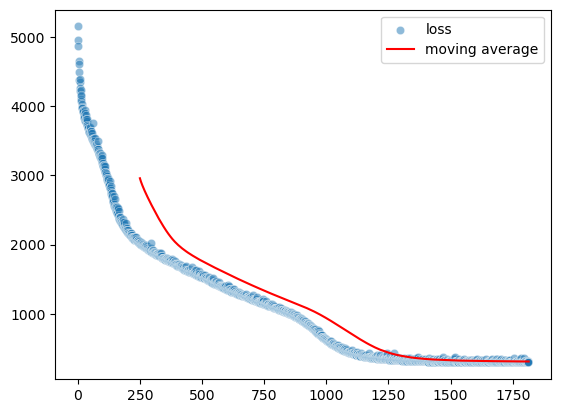

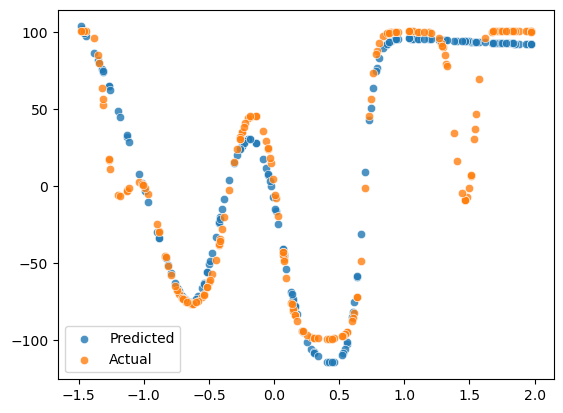

In [ ]:
# test 122 to beat

network_multiexperiment = network(architecture = np.array([1, 15, 15, 1]), 
                        activation_functions = [None, sigmoid, sigmoid, linear], 
                        activation_derivatives = [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 
                        initiation_method = 'xavier')	

window = 250
early_stopping_learn(network_multiexperiment,
                     x_train = multimodal_sparse_train_X,
                     y_train = multimodal_sparse_train_Y,
                     x_test = multimodal_sparse_test_X,
                     y_test = multimodal_sparse_test_Y,
                     patience = 150,
                     window = window,
                     task = 'regression',
                     epochs_number = 25000,
                     step = 0.01,
                     rmsprop_dumping = 0.90,
                     batch_size = 8,
                     dropout_p = 0,
                     reg_type = 'L1',
                     lambda_= 0.001)

m_average = np.convolve(network_multiexperiment.loss_record, np.ones(window)/window, mode='valid')
m_average = np.concatenate((np.full(window, np.nan), m_average))
print('Final loss score: ', network_multiexperiment.loss_record[-1])
sns.scatterplot(network_multiexperiment.loss_record, label = 'loss', alpha=0.5)
sns.lineplot(m_average, label = 'moving average', color='red')
test_regression(x=multimodal_sparse_test_X, y=multimodal_sparse_test_Y, size=200, network=network_multiexperiment)

In [76]:
print('rings5_sparse_train size: ', len(rings5_sparse_train))
print('rings5_sparse_test size: ', len(rings5_sparse_test))

rings5_sparse_train size:  200
rings5_sparse_test size:  2000


Early stopping epoch 687
Final loss score:  0.25337425339909
Final f1_score:  0.9028571428050389
test cross entropy: 0.6425397284933272
test f-measure: 0.6425397284933272


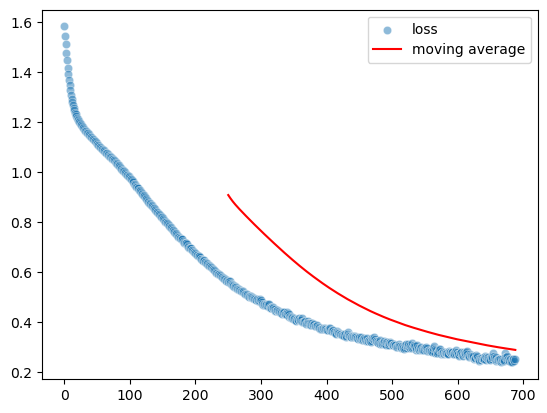

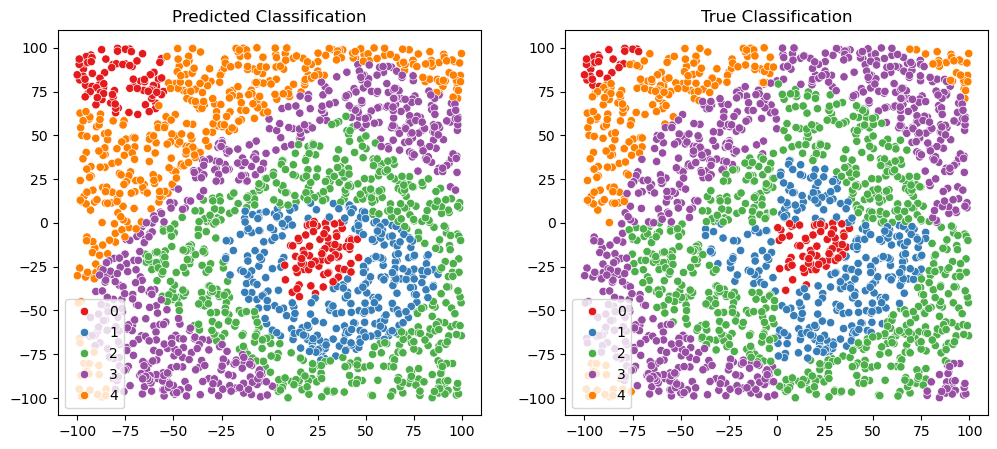

In [ ]:
# test 0.62 to beat

network_rings5 = network(architecture = np.array([2, 64, 64, 64, 5]),
                        activation_functions = [None, ReLU, ReLU, ReLU, softmax], 
                        activation_derivatives = [None, ReLU_derivative, ReLU_derivative, ReLU_derivative, None], 
                        initiation_method = 'xavier')

window = 250
early_stopping_learn(network_rings5,
                     x_train = [rings5_sparse_train_X, rings5_sparse_train_Y],
                     y_train = rings5_sparse_train_C,
                     x_test = [rings5_sparse_test_X, rings5_sparse_test_Y],
                     y_test = rings5_sparse_test_C,
                     patience = 150,
                     window = window,
                     task = 'classification',
                     epochs_number = 5000,
                     step = 0.0001,
                     rmsprop_dumping = 0.90,
                     batch_size = 4,
                     dropout_p = 0.1,
                     reg_type = 'L2',
                     lambda_= 0.001)

m_average = np.convolve(network_rings5.loss_record, np.ones(window)/window, mode='valid')
m_average = np.concatenate((np.full(window, np.nan), m_average))
print('Final loss score: ', network_rings5.loss_record[-1])
print('Final f1_score: ', network_rings5.f1_score[-1])
sns.scatterplot(network_rings5.loss_record, label = 'loss', alpha=0.5)
sns.lineplot(m_average, label = 'moving average', color='red')
test_classification([rings5_sparse_test_X, rings5_sparse_test_Y], rings5_sparse_test_C, network_rings5)

In [77]:
print('rings3_balance_train size: ', len(rings3_balance_train))
print('rings3_balance_test size: ', len(rings3_balance_test))

rings3_balance_train size:  2060
rings3_balance_test size:  2000


Early stopping epoch 1831
Final loss score:  0.04715376337568929
Final f1_score:  0.9852997101436978
test cross entropy: 0.8667719023544398
test f-measure: 0.8667719023544398


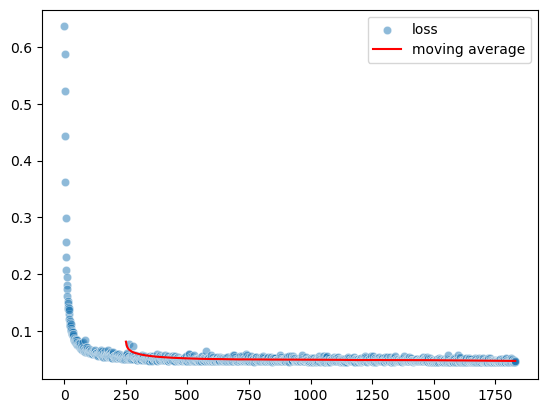

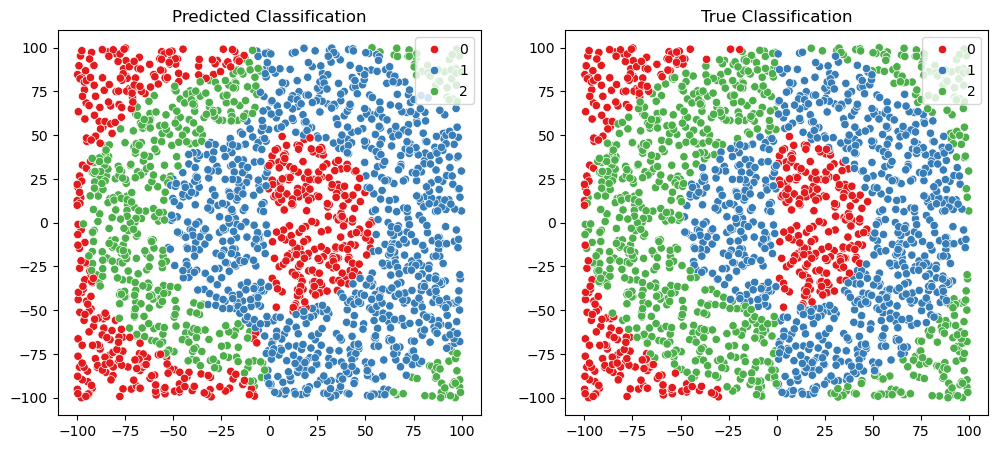

In [41]:
# test 0.90 to beat

network_rings3 = network(architecture = np.array([2, 64, 64, 3]),
                        activation_functions = [None, ReLU, ReLU, softmax], 
                        activation_derivatives = [None, ReLU_derivative, ReLU_derivative, None], 
                        initiation_method = 'xavier')

window = 250
early_stopping_learn(network_rings3,
                     x_train = [rings3_balance_train_X, rings3_balance_train_Y],
                     y_train = rings3_balance_train_C,
                     x_test = [rings3_balance_test_X, rings3_balance_test_Y],
                     y_test = rings3_balance_test_C,
                     patience = 150,
                     window = window,
                     task = 'classification',
                     epochs_number = 5000,
                     step = 0.001,
                     rmsprop_dumping = 0.90,
                     batch_size = 32,
                     dropout_p = 0,
                     reg_type = 'L2',
                     lambda_= 0.001)

m_average = np.convolve(network_rings3.loss_record, np.ones(window)/window, mode='valid')
m_average = np.concatenate((np.full(window, np.nan), m_average))
print('Final loss score: ', network_rings3.loss_record[-1])
print('Final f1_score: ', network_rings3.f1_score[-1])
sns.scatterplot(network_rings3.loss_record, label = 'loss', alpha=0.5)
sns.lineplot(m_average, label = 'moving average', color='red')
test_classification([rings3_balance_test_X, rings3_balance_test_Y], rings3_balance_test_C, network_rings3)

In [78]:
print('xor3_balance_train size: ', len(xor3_balance_train))
print('xor3_balance_test size: ', len(xor3_balance_test))

xor3_balance_train size:  1050
xor3_balance_test size:  800


Early stopping epoch 613
Final loss score:  0.01103325909287755
Final f1_score:  0.9724373276823208
test cross entropy: 0.8412320393252329
test f-measure: 0.8412320393252329


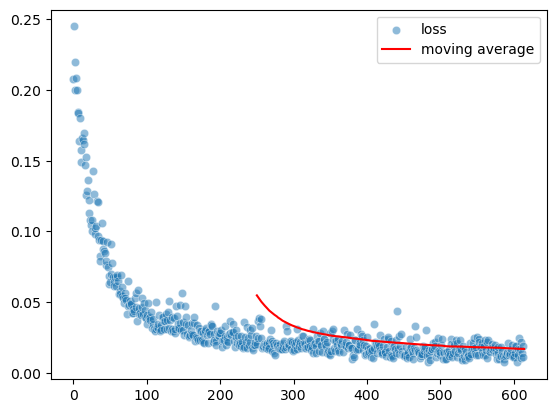

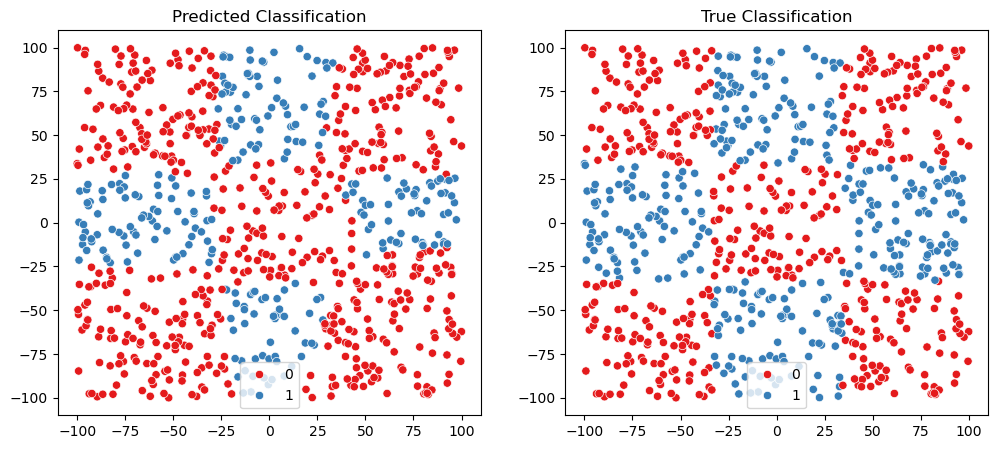

In [39]:
# test 0.86 to beat

network_xor = network(architecture = np.array([2, 32, 32, 2]),
                        activation_functions = [None, ReLU, ReLU, softmax], 
                        activation_derivatives = [None, ReLU_derivative, ReLU_derivative, None], 
                        initiation_method = 'xavier')

window = 250
early_stopping_learn(network_xor,
                     x_train = [xor3_balance_train_X, xor3_balance_train_Y],
                     y_train = xor3_balance_train_C,
                     x_test = [xor3_balance_test_X, xor3_balance_test_Y],
                     y_test = xor3_balance_test_C,
                     patience = 300,
                     window = window,
                     task = 'classification',
                     epochs_number = 5000,
                     step = 0.005,
                     rmsprop_dumping = 0.90,
                     batch_size = 64,
                     dropout_p = 0.2,
                     reg_type = 'L2',
                     lambda_= 0.00001)

m_average = np.convolve(network_xor.loss_record, np.ones(window)/window, mode='valid')
m_average = np.concatenate((np.full(window, np.nan), m_average))
print('Final loss score: ', network_xor.loss_record[-1])
print('Final f1_score: ', network_xor.f1_score[-1])
sns.scatterplot(network_xor.loss_record, label = 'loss', alpha=0.5)
sns.lineplot(m_average, label = 'moving average', color='red')
test_classification([xor3_balance_test_X, xor3_balance_test_Y], xor3_balance_test_C, network_xor)

In [ ]:
# Jak się okazuje regularyzacja nie jest narzędziem działającym bez trudu. Nie udało mi się osiągnąć sensownej poprawy wyników dla wszystkich zbiorów. Przed każdym treningiem zapisałem sobie najlepszy wynik jaki udało mi się uzyskać (na teście) próbując przetrenować się ile wlezie na zbiorze treningowym.

# Regularyzacja L1 i L2 są mało inwazyjne i łatwo z nich korzystać, trochę jak z momentów. Jednak taki dropout jest dla mnie nie do okiełznania. Bardzo zaburza on proces uczenia i łatwo z nim przesadzić. Tam gdzie udało mi się go urzyć nie blokując zupełnie procesu uczenia nie dał on dużej poprawy wyników.